In [22]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import AutoImageProcessor
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score

In [23]:
import splitfolders

input_folder = r"C:\Users\ADMIN\Documents\Document\USTH\B3\Luan_tot_nghiep\dataset\mango leaf dataset"
output_folder = r"C:\Users\ADMIN\Documents\Document\USTH\B3\Luan_tot_nghiep\dataset\mango leaf split huggingface"

# Chia train/test theo tỷ lệ 80/20
splitfolders.ratio(
    input_folder, 
    output=output_folder, 
    seed=42, 
    ratio=(.8, .2)
)


Copying files: 4000 files [00:02, 1615.88 files/s]


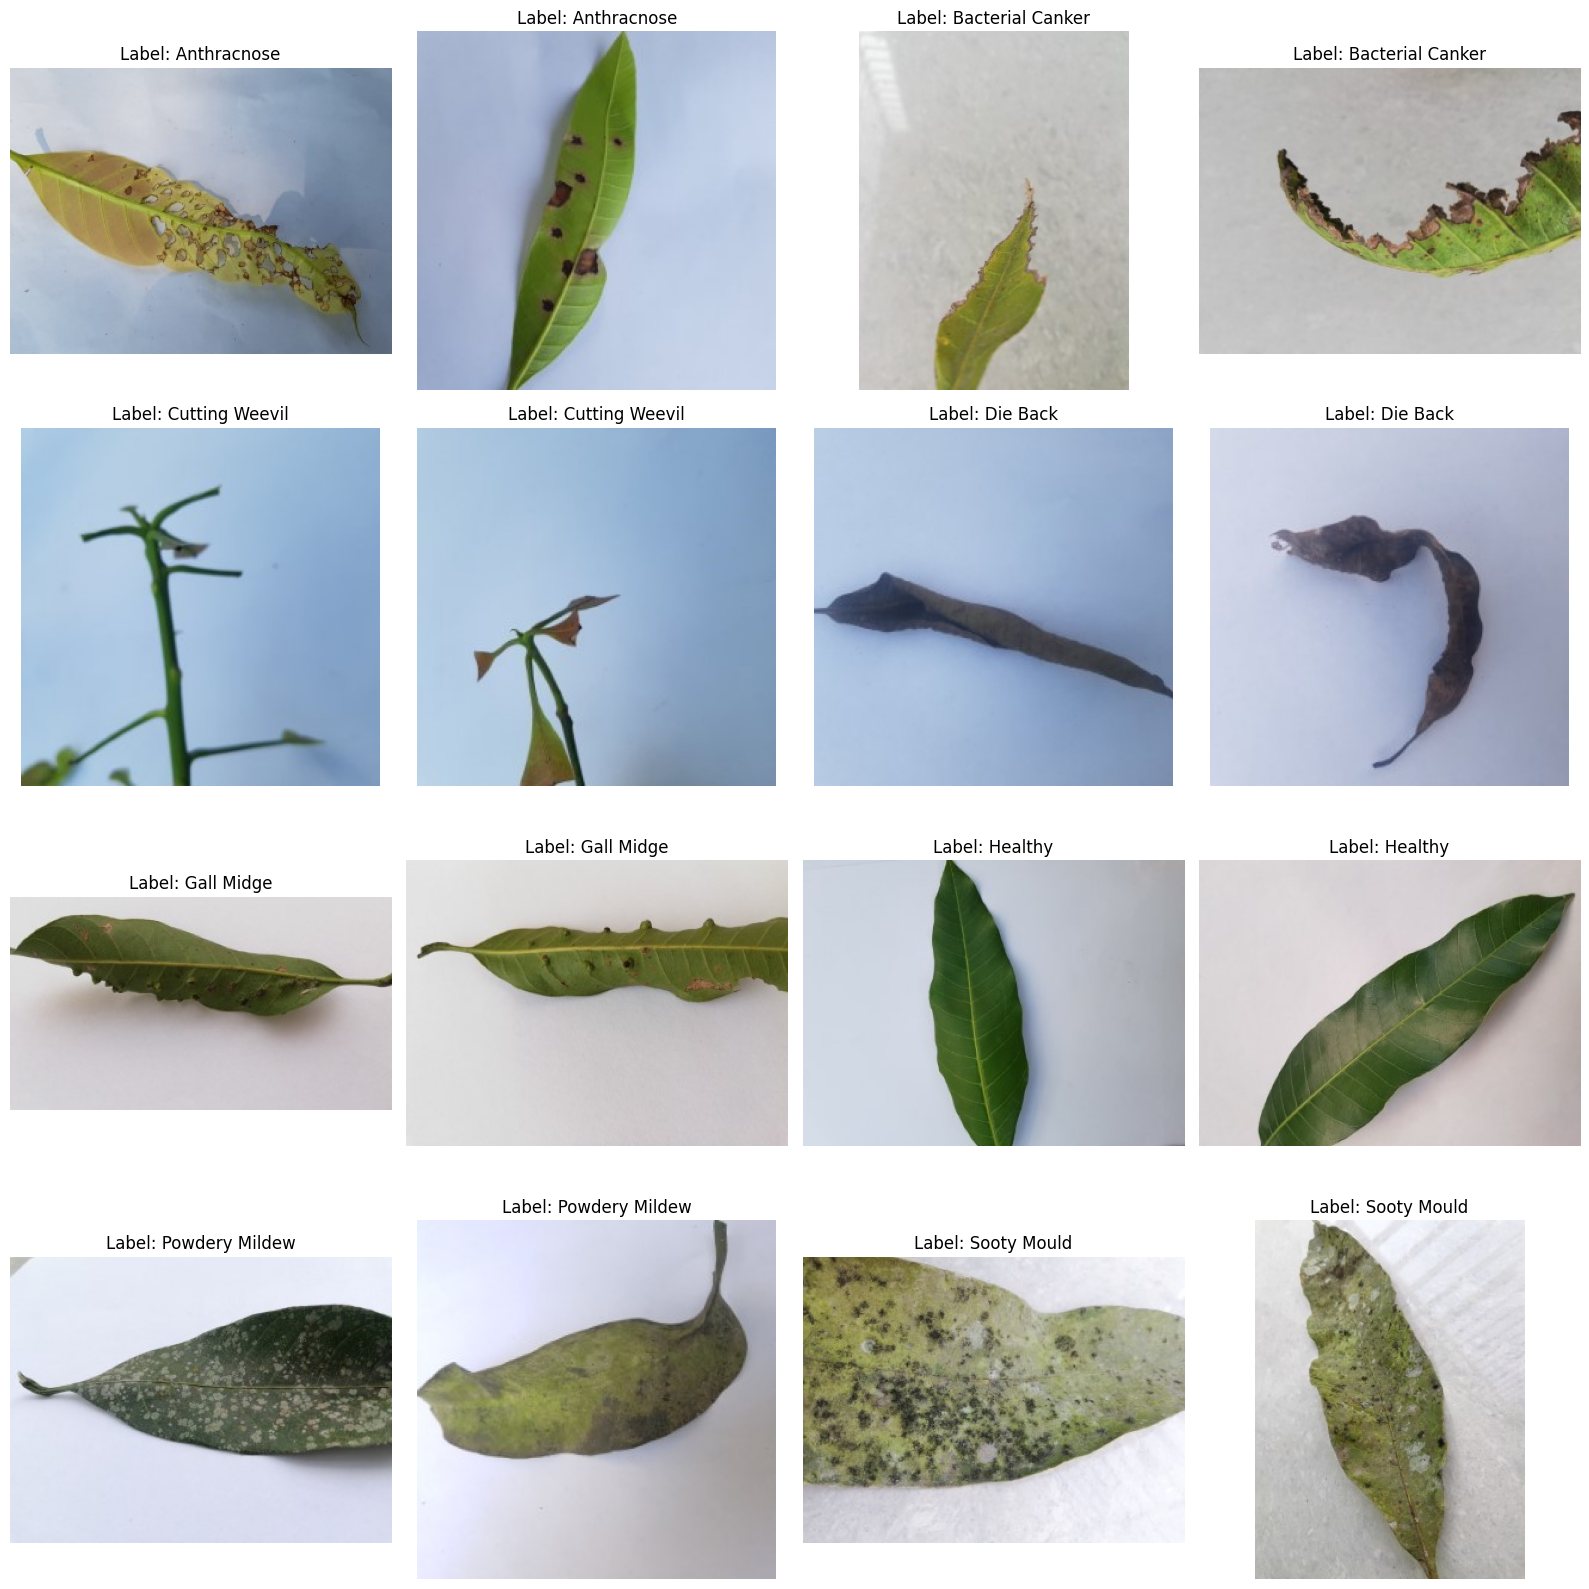

In [24]:
# Đường dẫn folder train/test hoặc folder gốc đều được
folder_path = r"C:\Users\ADMIN\Documents\Document\USTH\B3\Luan_tot_nghiep\dataset\mango leaf split huggingface\train" 
# hoặc folder_path = r"C:\Users\ADMIN\Documents\Document\USTH\B3\Luan_tot_nghiep\dataset\mango leaf dataset"

labels = sorted(os.listdir(folder_path))
sample_imgs = []

for label in labels:
    label_folder = os.path.join(folder_path, label)
    all_imgs = os.listdir(label_folder)
    chosen_imgs = random.sample(all_imgs, 2) if len(all_imgs) >= 2 else all_imgs
    for img_file in chosen_imgs:
        img_path = os.path.join(label_folder, img_file)
        sample_imgs.append((img_path, label))

# Sắp xếp để 4 ảnh/1 hàng
n_images = len(sample_imgs)
n_cols = 4
n_rows = (n_images + n_cols - 1) // n_cols

plt.figure(figsize=(16, n_rows*4))

for idx, (img_path, label) in enumerate(sample_imgs):
    plt.subplot(n_rows, n_cols, idx+1)
    img = Image.open(img_path)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Label: {label}", fontsize=12)

plt.tight_layout()
plt.show()

Make sure the fine-tune process will have test and train accu

In [25]:
from datasets import load_dataset

data_dir = r"C:\Users\ADMIN\Documents\Document\USTH\B3\Luan_tot_nghiep\dataset\mango leaf split huggingface"
dataset = load_dataset("imagefolder", data_dir=data_dir)

print(dataset)
print("Train samples:", len(dataset['train']))
print("Validation samples:", len(dataset['validation']))
print("Labels:", dataset['train'].features['label'].names)


Generating train split: 3200 examples [00:00, 12692.37 examples/s]
Generating validation split: 1600 examples [00:00, 11073.21 examples/s]


DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 3200
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 1600
    })
})
Train samples: 3200
Validation samples: 1600
Labels: ['Anthracnose', 'Bacterial Canker', 'Cutting Weevil', 'Die Back', 'Gall Midge', 'Healthy', 'Powdery Mildew', 'Sooty Mould']


TIỀN XỬ LÝ ẢNH VỚI PROCESSOR HUGGING FACE

In [26]:
model_checkpoint = "juniorjukeko/swin-tiny-patch4-window7-224_ft_mango_leaf_disease"
processor = AutoImageProcessor.from_pretrained(model_checkpoint)

def transform(example_batch):
    inputs = processor([x for x in example_batch['image']], return_tensors='pt')
    inputs['label'] = example_batch['label']
    return inputs

prepared_ds = dataset.with_transform(transform)

TẠO MODEL, TRAINER, TRAINING ARGUMENTS

In [27]:

model = AutoModelForImageClassification.from_pretrained(model_checkpoint)

def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    return {
        "accuracy": accuracy_score(p.label_ids, preds)
    }

training_args = TrainingArguments(
    output_dir="./results-swin",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    remove_unused_columns=False,
    report_to="none",
    load_best_model_at_end=True,           # Lưu best model dựa trên eval_accuracy
    metric_for_best_model="eval_accuracy",
    greater_is_better=True,
    save_total_limit=2,                    # Chỉ lưu 2 checkpoint gần nhất (tùy chọn)
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["validation"],
    compute_metrics=compute_metrics,
)

c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [28]:
# Huấn luyện model
train_result = trainer.train()

# Lưu best model vào folder mới
trainer.save_model("./best_model")
processor.save_pretrained("./best_model")


Epoch,Training Loss,Validation Loss,Accuracy
1,0.018800,0.000010,1.000000
2,0.007500,0.072188,0.988750
3,0.006700,0.006389,0.998750
4,0.011000,0.006517,0.998750
5,0.000500,0.012590,0.998750
6,0.008400,0.000001,1.000000
7,0.000000,0.000001,1.000000
8,0.000000,0.000001,1.000000
9,0.000000,0.000001,1.000000
10,0.000000,0.000001,1.000000


['./best_model\\preprocessor_config.json']

Test trên tập test


In [29]:
from transformers import AutoImageProcessor, AutoModelForImageClassification

model_path = "./best_model"
processor = AutoImageProcessor.from_pretrained(model_path)
model = AutoModelForImageClassification.from_pretrained(model_path)


In [30]:
import random

# Lấy tập validation gốc (không transform)
val_ds = dataset['validation']

# Chuẩn bị lấy 2 ảnh mỗi label
label_names = val_ds.features['label'].names
label_to_indices = {i: [] for i in range(len(label_names))}

for idx, ex in enumerate(val_ds):
    label = ex['label']
    if len(label_to_indices[label]) < 2:
        label_to_indices[label].append(idx)
    # Dừng nếu đã đủ 2 ảnh mỗi label
    if all(len(v) == 2 for v in label_to_indices.values()):
        break

sample_indices = []
for indices in label_to_indices.values():
    sample_indices.extend(indices)


In [31]:
from PIL import Image
import torch

images = [val_ds[i]['image'] for i in sample_indices]
labels_true = [val_ds[i]['label'] for i in sample_indices]

# Chuyển ảnh qua processor
inputs = processor(images, return_tensors="pt")
with torch.no_grad():
    outputs = model(**inputs)
    preds = outputs.logits.argmax(dim=1).cpu().numpy()


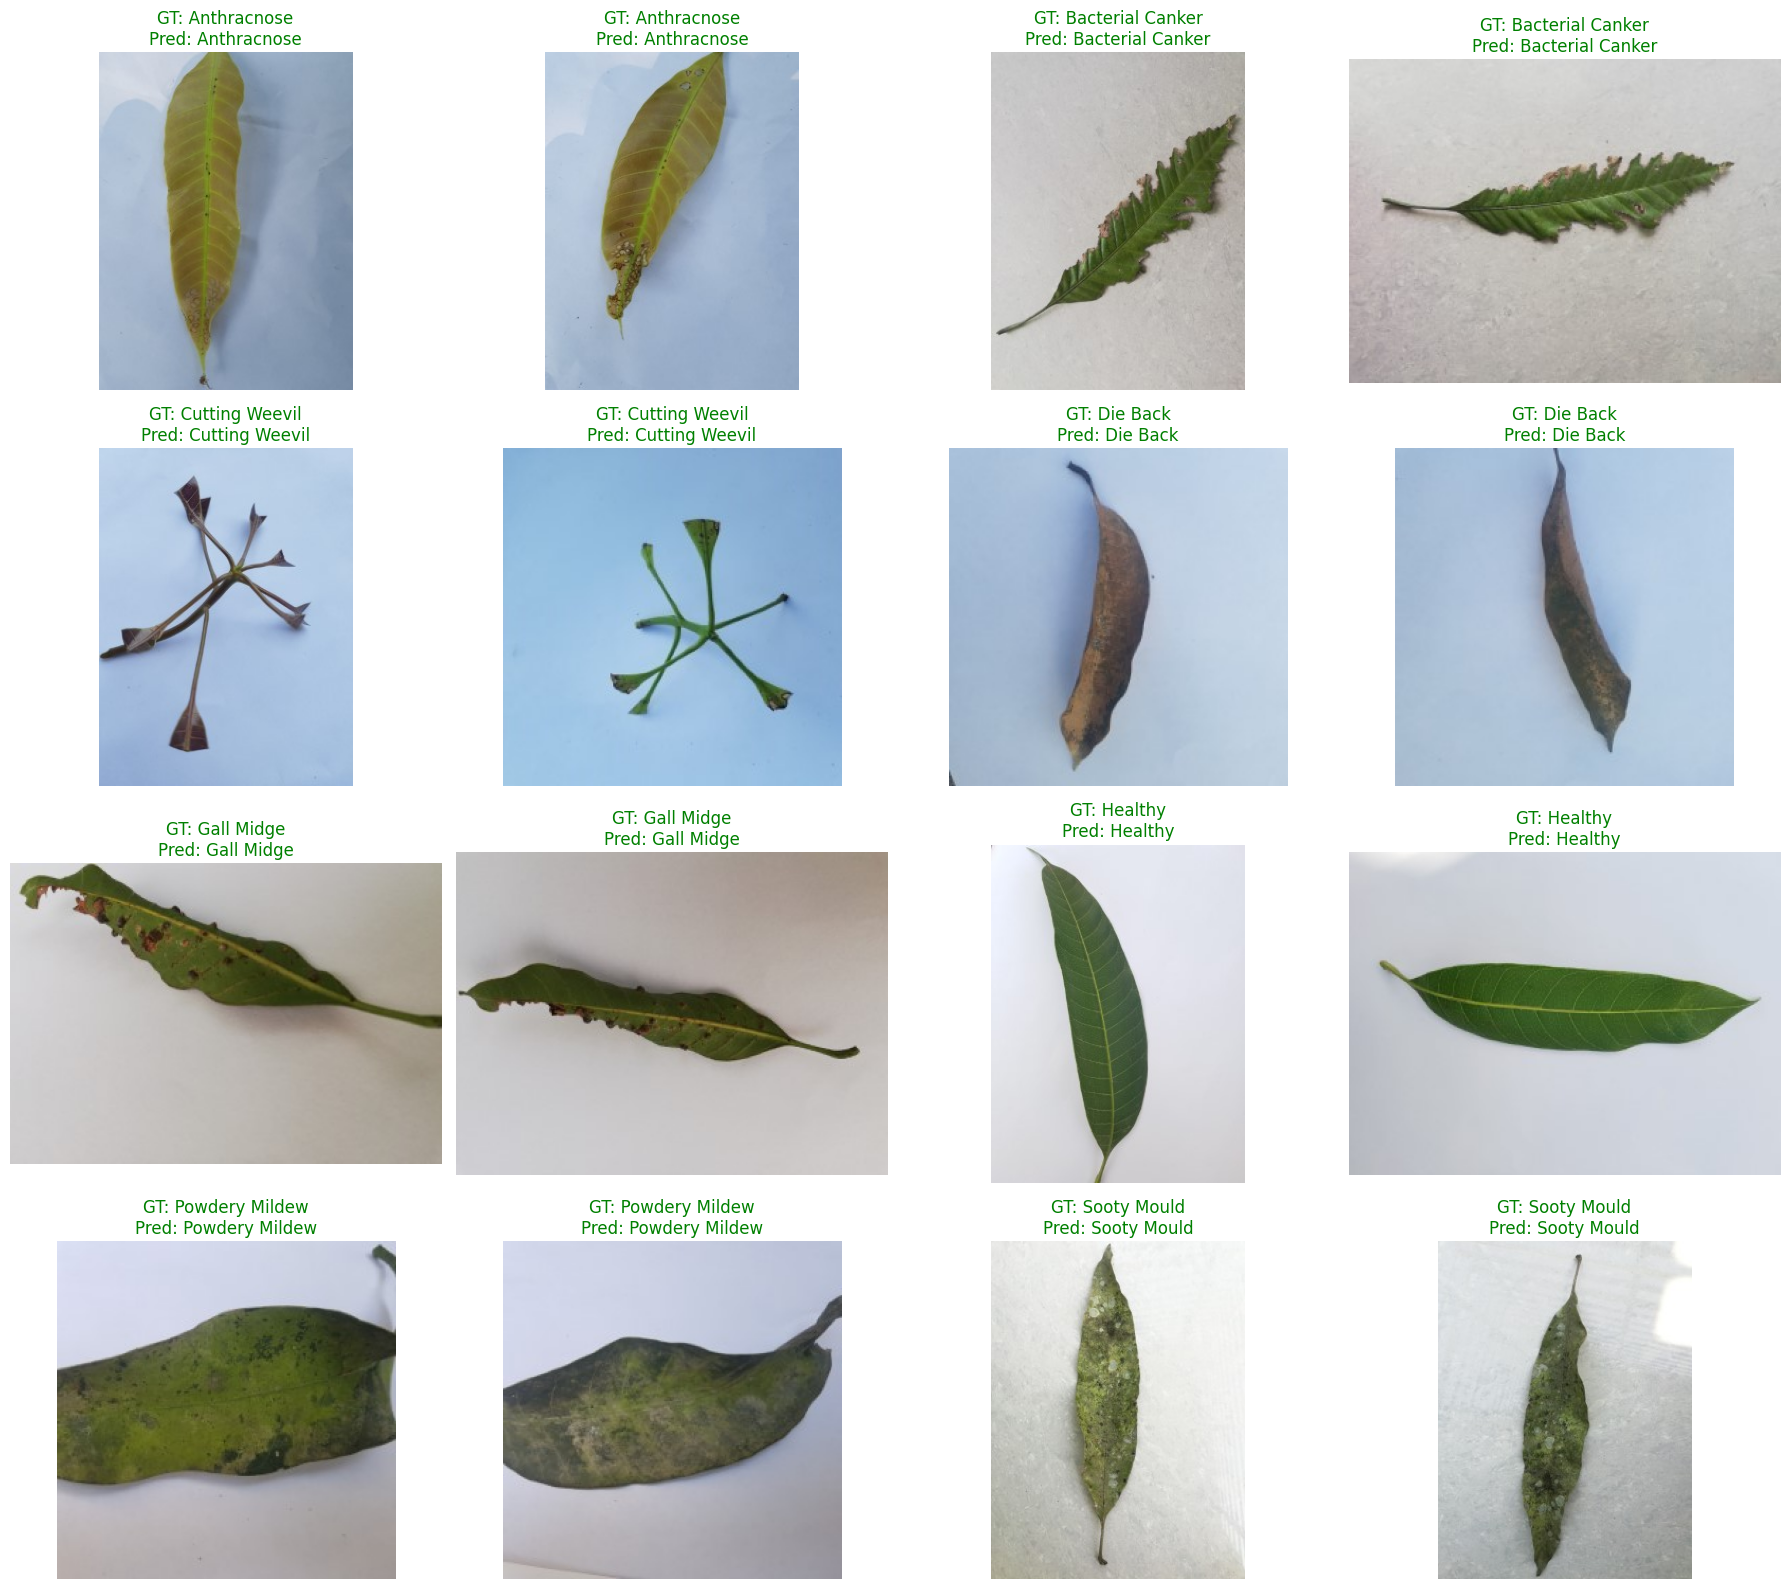

In [32]:
import matplotlib.pyplot as plt

n_images = len(images)
n_cols = 4
n_rows = (n_images + n_cols - 1) // n_cols

plt.figure(figsize=(18, n_rows * 4))
for idx, img in enumerate(images):
    plt.subplot(n_rows, n_cols, idx+1)
    plt.imshow(img)
    true_label = label_names[labels_true[idx]]
    pred_label = label_names[preds[idx]]
    color = "green" if pred_label == true_label else "red"
    plt.title(f"GT: {true_label}\nPred: {pred_label}", color=color, fontsize=12)
    plt.axis('off')

plt.tight_layout()
plt.show()


In [33]:
# Đánh giá model trên tập validation (test)
test_results = trainer.evaluate(eval_dataset=prepared_ds["validation"])
print(f"Test Loss: {test_results['eval_loss']:.4f}")
print(f"Test Accuracy: {test_results['eval_accuracy']*100:.2f}%")


Test Loss: 0.0000
Test Accuracy: 100.00%
